## Amazon Stock Price Prediction

Data Source: Yahoo Finance using `yfinance`module

**Index**

1. Data Extraction

2. Formatting data for time series

3. Feature engineering

4. ARIMA model

6. LSTM model with one feature

7. LSTM model with multiple features





In [135]:
# For first time users. Install yfinance for yahoo finance api
#pip install yfinance

#pip install xgboost

#pip install keras
#pip install tensorflow

In [56]:
#import math
#import time
import datetime

import pandas as pd
import numpy as np
import seaborn as sns

# import yahoo finance and other libraries
import yfinance as yf

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#import any one scalar for normalizing data for LSTMs
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

#evaluation metric
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for feature selection
import xgboost as xgb

#to ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Fetch Amaznon AMZN stock data and arrange
ticker = yf.Ticker('AMZN')
df = ticker.history(start='2012-01-01', end='2022-01-01')
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.iloc[:,0:5]
df.head()

,Date,Open,High,Low,Close
0,2012-01-03,8.7945,8.9740,8.7775,8.9515
1,2012-01-04,8.9605,9.0250,8.8035,8.8755
2,2012-01-05,8.7970,8.9125,8.7025,8.8805
3,2012-01-06,8.9035,9.2325,8.8750,9.1305
4,2012-01-09,9.1380,9.2185,8.8500,8.9280


In [45]:
#some useful commands can be found here: https://analyticsindiamag.com/hands-on-guide-to-using-yfinance-api-in-python/
ticker.recommendations

,Firm,To Grade,From Grade,Action
Date,,,,
2011-12-29 12:47:00,PiperJaffray,,,main
2012-02-15 07:33:00,PiperJaffray,Overweight,,main
2012-02-16 06:17:00,Morgan Stanley,Equal-Weight,,down
2012-04-02 06:06:00,Bank oferica,Neutral,,down
2012-04-27 06:21:00,Bank oferica,Buy,,up
...,...,...,...,...
2022-11-02 17:23:28,Tigress Financial,Buy,,main
2022-11-14 11:58:40,Rosenblatt,Neutral,,main
2022-11-15 12:46:44,MoffettNathanson,Outperform,,init


In [3]:
# for ARIMA we will only use one variable 'close'
adf = df.iloc[:,[0,4]]
adf.head(2)

,Date,Close
0,2012-01-03,8.9515
1,2012-01-04,8.8755


In [57]:
print('There are {} number of records in the dataset.'.format(df.shape[0]))

There are 2517 number of records in the dataset.


In [4]:
adf['Date']= pd.to_datetime(adf['Date'])
adf.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [59]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Close   2517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


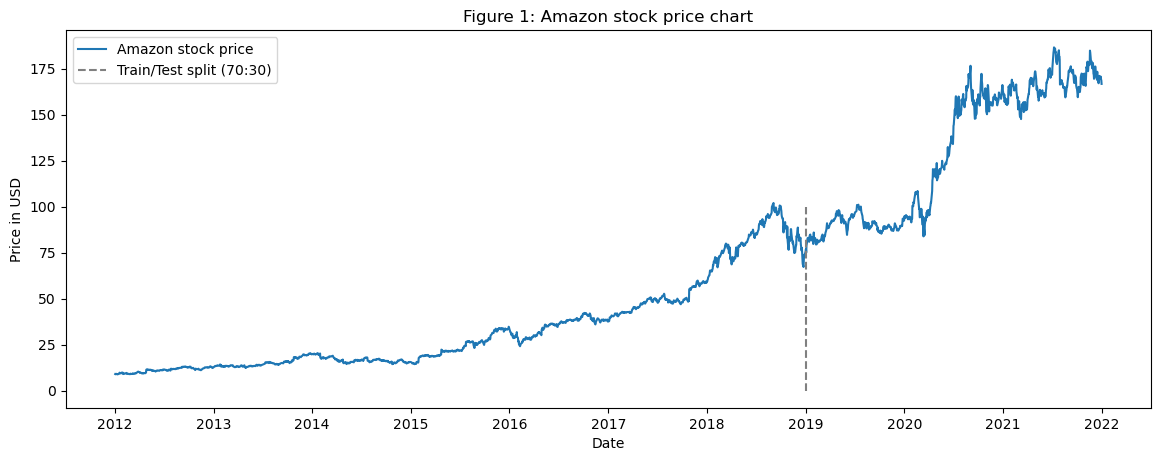

In [5]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(adf['Date'], adf['Close'], label='Amazon stock price')
plt.vlines(datetime.date(2019,1,3), 0,100, linestyles='--', colors='gray', label='Train/Test split (70:30)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Figure 1: Amazon stock price chart')
plt.legend()
plt.show()

# **Feature Engineering**

Let us create more technical indicators to help the model to learn more.

**1.   EMA:** An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/e/ema.asp


**2. Moving average ( 7 day and 21 day):** Moving averages are calculated to identify the trend direction of a stock or to determine its support and resistance levels. It is a trend-following or lagging, indicator because it is based on past prices.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/m/movingaverage.asp

**3. Momentum:** Momentum is the rate of acceleration of a security's price—that is, the speed at which the price is changing.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/m/marketmomentum.asp



In [6]:
#function to generate feature technical indicators

def technical_indicators(data): 
    
    
    # Create 7 and 21 days Moving Average
    data['MA7'] = data['Close'].rolling(window = 7).mean()
    data['MA21'] = data['Close'].rolling(window = 21).mean()
    
    #Create MACD
    data['12EMA'] = data['Close'].ewm(span=12).mean()
    data['26EMA'] = data['Close'].ewm(span=26).mean()
    data['MACD'] = (data['12EMA']-data['26EMA'])
    
    #Create Exponential moving average
    data['EMA'] = data['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    data['MOMENTUM'] = (data['Close']/100)-1
    
    return data

In [7]:
#create new dataframe
tdf = technical_indicators(df)
tdf.head()

,Date,Open,High,Low,Close,MA7,MA21,12EMA,26EMA,MACD,EMA,MOMENTUM
0,2012-01-03,8.7945,8.9740,8.7775,8.9515,NaN,NaN,8.951500,8.951500,0.000000,8.951500,-0.910485
1,2012-01-04,8.9605,9.0250,8.8035,8.8755,NaN,NaN,8.910333,8.912038,-0.001705,8.894500,-0.911245
2,2012-01-05,8.7970,8.9125,8.7025,8.8805,NaN,NaN,8.898689,8.900707,-0.002018,8.884808,-0.911195
3,2012-01-06,8.9035,9.2325,8.8750,9.1305,NaN,NaN,8.971863,8.964947,0.006916,9.050650,-0.908695
4,2012-01-09,9.1380,9.2185,8.8500,8.9280,NaN,NaN,8.959946,8.956379,0.003567,8.968546,-0.910720


# **ARIMA - Auto Regressive Integrated Moving Average** 
ARIMA predictions as a feature:

ARIMA is specified by theree order parameters (p,d,q)


**AR (p) Autoregression:** An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.
<br/><br/>


**I (d) Integration:** uses differencing of observations (subtracting an observation with an obseervation from the previous step) in order to make the time series stationary.
<br/><br/>


**MA (q) Moving Average:** A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


**p: The number of lag observations included in the model, also called the lag order.**
**d: The number of times that the raw observations are differenced, also called the degree of differencing.**
**q: The size of the moving average window, also called the order of moving average.**

Learn how to calculate p,d,q here https://github.com/swapnilin/TS/blob/main/T2-Monthly-Forecasting-using-ARIMA.ipynb

 
**First, we will fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.**


In [8]:
dfa = df[['Date','Close']]

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = dfa['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2517
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4597.837
Date:                Thu, 08 Dec 2022   AIC                           9207.674
Time:                        15:49:43   BIC                           9242.657
Sample:                             0   HQIC                          9220.370
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0261      0.011     -2.474      0.013      -0.047      -0.005
ar.L2         -0.0064      0.010     -0.614      0.539      -0.027       0.014
ar.L3         -0.0756      0.009     -8.019      0.0

 **SUMMARY OF THE ARIMA MODEL**
 
**A good starting point for the AR parameter of the model may be 5 which we did**

**From the summary of the ARIMA we can see that most P-values are greater than 0.05.The model should be great!**

**The difference between AIC and BIC is low so this indicates this is a good model**


### Plot auto correlation plot

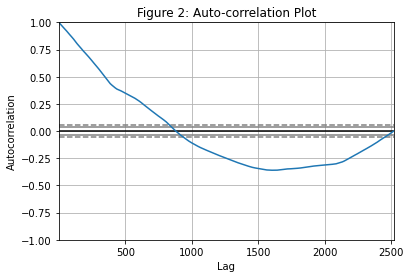

<Figure size 800x560 with 0 Axes>

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.title('Figure 2: Auto-correlation Plot')
plt.figure(figsize=(10, 7), dpi=80)
plt.show()


**We can see in figure 2, there is a positive correlation with the first 0 to 800 lags**


## Prepare and Train Data with ARIMA

In [11]:
series = dfa['Close']
X = series.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    new = test[i]
    history.append(new)

tdf['ARIMA'] = pd.DataFrame(predictions)

In [12]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6.103


In [13]:
len(predictions), len(train)

(756, 1761)

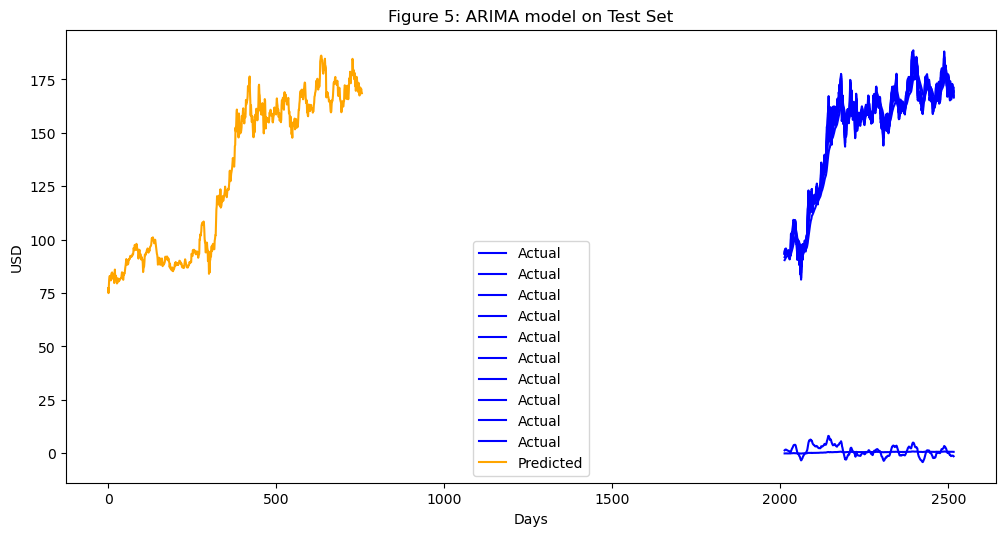

In [60]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='Blue', label='Actual')
plt.plot(predictions, color='Orange', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Test Set')
plt.legend()
plt.show()

**As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM.**

**Note: ARIMA values are only available for the size of test set, rest will show as NaN**

In [72]:
tdf

,Date,Open,High,Low,Close,MA7,MA21,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,2012-01-03,8.794500,8.974000,8.777500,8.951500,NaN,NaN,8.951500,8.951500,0.000000,8.951500,-0.910485,77.313624
1,2012-01-04,8.960500,9.025000,8.803500,8.875500,NaN,NaN,8.910333,8.912038,-0.001705,8.894500,-0.911245,74.981736
2,2012-01-05,8.797000,8.912500,8.702500,8.880500,NaN,NaN,8.898689,8.900707,-0.002018,8.884808,-0.911195,78.591700
3,2012-01-06,8.903500,9.232500,8.875000,9.130500,NaN,NaN,8.971863,8.964947,0.006916,9.050650,-0.908695,81.473986
4,2012-01-09,9.138000,9.218500,8.850000,8.928000,NaN,NaN,8.959946,8.956379,0.003567,8.968546,-0.910720,82.875644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-12-27,171.037003,172.942993,169.215500,169.669495,169.737071,172.019573,170.872064,172.005465,-1.133401,170.080147,0.696695,NaN
2513,2021-12-28,170.182495,172.175995,169.135498,170.660995,169.992785,171.802097,170.839592,171.905875,-1.066283,170.467379,0.706610,NaN
2514,2021-12-29,170.839996,171.212006,168.600494,169.201004,169.876142,171.379359,170.587501,171.705514,-1.118013,169.623129,0.692010,NaN
2515,2021-12-30,169.699997,170.888000,168.524002,168.644501,170.099786,171.059883,170.288578,171.478772,-1.190194,168.970710,0.686445,NaN


# **Feature Importance using XGBoost**

**Having so many features we have to consider whether all of them are really indicative of the direction AMZN stock will take. There are many ways to test feature importance, we will use XGBoost, because it gives one of the best results in both classification and regression problems.**

In [15]:
def features(data):
    data = data.copy()
    y = data['Close']
    X = df.drop(['Date','Close'], axis=1)
    
    train_samples = int(X.shape[0] * 0.70)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [16]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = features(df)

In [17]:
# find these hyper-parameters using grid search CV
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [18]:
#fit the model
xgbModel = regressor.fit(X_train_FI,y_train_FI,
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
                         verbose=False)

In [19]:
eval_result = regressor.evals_result()

In [20]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

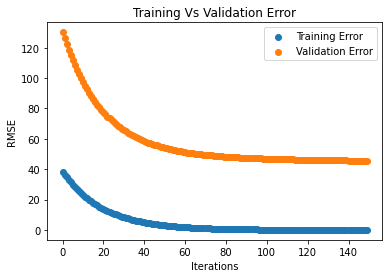

In [21]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

**The difference between validation and training error shows an underfit model. However, the way training and testing data is split, this is expected.**

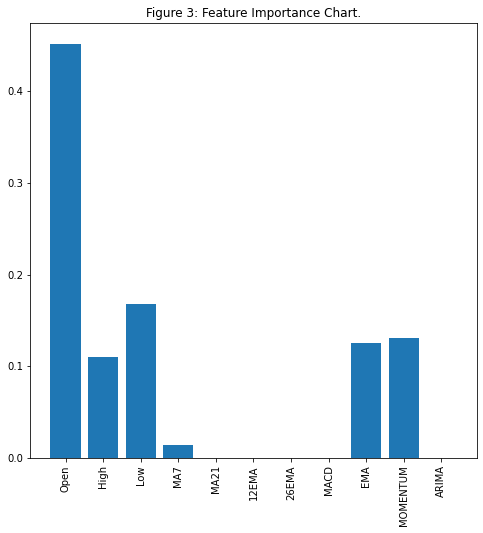

In [22]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 3: Feature Importance Chart.')
plt.show()

**MA7, EMA, and Momentum are among the important technical indicators** Features like Open, high, and low are bound to be close to Closing prices.


# **LSTM**

**LSTM is great at predicting stock market data. We are going to try to predict the closing prices, first using 1 feature Open(It has highest correlation to closing price) and then using multiple features**

**An LSTM Network has its origin in a RNN. But it can solve the memory loss by changing the neuron architecture.**

**The new neuron has 3 gates, each with a different goal. The gates are:**

**1.Input Gate**

**2.Output Gate**

**3.Forget Gate**

**An LSTM Neuron receives input from its previous state:**

How it works: You input the data one timestep at a time to the LSTM cell. And each timestep the cell not only recieves the new input, but it recieves the last timestep's output and what is called the cell state, a vector that carries information about what happened in the past. Within the cell you have trained gates (basically small neural nets) that decide, based on the three inputs, what to forget from the past cell state, what to remember (or add) to the new state, and what to output this timestep

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)




**Steps for LSTM**

**1. Clean up the data**

**2. Create a train, validate, and test set**

**3. Normalize data** 

**4. Create feature and label set**

**6. Train, validate data and check with test set**

**7. Make predictions**



In [288]:
# Let us drop MA7 and MA21 since it has a lot of NaN's
lstm_df = df.drop(columns=['Date','MA7','MA21'])
lstm_df.head(7)

,Open,High,Low,Close,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,8.7945,8.9740,8.7775,8.9515,8.951500,8.951500,0.000000,8.951500,-0.910485,77.313624
1,8.9605,9.0250,8.8035,8.8755,8.910333,8.912038,-0.001705,8.894500,-0.911245,74.981736
2,8.7970,8.9125,8.7025,8.8805,8.898689,8.900707,-0.002018,8.884808,-0.911195,78.591700
3,8.9035,9.2325,8.8750,9.1305,8.971863,8.964947,0.006916,9.050650,-0.908695,81.473986
4,9.1380,9.2185,8.8500,8.9280,8.959946,8.956379,0.003567,8.968546,-0.910720,82.875644
5,9.0550,9.1200,8.8550,8.9670,8.961660,8.958506,0.003154,8.967514,-0.910330,82.722979
6,8.9820,9.0385,8.9095,8.9450,8.957942,8.956104,0.001838,8.952498,-0.910550,82.921498


In [289]:
#shape of the dataset
lstm_df.shape

(2517, 10)

In [290]:
#import keras layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

**Split dataset into train,test and validate sets**

In [291]:
#creating test, train and validate trains
train, validate, test = np.split(lstm_df, [int(.6*len(lstm_df)), int(.8*len(lstm_df))])

In [292]:
train.shape, validate.shape, test.shape

((1510, 10), (503, 10), (504, 10))

### Model with only one variable 'Open'

In [293]:
# create arrays
opentrain = train.iloc[:, 0:1].values
openval= validate.iloc[:,0:1].values
opentest = test.iloc[:,0:1].values

**Normalization**
The data is not normalized and the range for each column varies. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. 

In [294]:
opentrain.shape

(1510, 1)

**Note:** <br/>
1. When you scale a dataframe, if it has one variable now, it expects only one variable later during inverse_transform. If you scale a dataframe with 5 variables, the scaler expects 5 variables while inverse_transform.
So, during inverse transfrom, if you are only expecting to re-scale one variable, during training fit your scaler only on one varible and transform the entire dataframe. (i.e. use `.fit` on a column, and `.transform` on the dataframe).
<br/>
2. Fit on training data and only transform the test and val data.

In [295]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
sopentrain = scaler.fit_transform(opentrain)
sopenval = scaler.transform(openval)
sopentest = scaler.transform(opentest)

We cannot fit the model like we normally do using ARIMA. We need to transform our data into something that looks like X and Y values.
This way it can be trained on a sequence rather than individual datapoints. 
Let us convert into n number of columns for X where we feed sequence of numbers then the final column as Y where we provide the next number in the sequence as output.
So let us convert an array (open-training) of values into a dataset matrix.

In [296]:
# use a simple for loop

def to_table(data, seq_size):
    x = []
    y = []

    for i in range(len(data)-seq_size):
        window = data[i:(i+seq_size), 0]
        x.append(window)
        y.append(data[i+seq_size, 0])
        
    return pd.DataFrame(x), pd.DataFrame(y)

In [297]:
# Re-arrange train data
traindata = to_table(sopentrain, seq_size=3)
valdata = to_table(sopenval, seq_size=3)
testdata = to_table(sopentest, seq_size=3)


In [298]:
sopentrain

array([[0.00201732],
       [0.00523727],
       [0.00206581],
       ...,
       [0.98459855],
       [0.97814893],
       [0.96811078]])

In [299]:
# the open data column has now been arranged in 4 columns, first 3 are the independant variables and the 4th is the dependant variable
traindata

(             0         1         2
 0     0.002017  0.005237  0.002066
 1     0.005237  0.002066  0.004132
 2     0.002066  0.004132  0.008680
 3     0.004132  0.008680  0.007070
 4     0.008680  0.007070  0.005654
 ...        ...       ...       ...
 1502  0.986053  0.971893  0.968188
 1503  0.971893  0.968188  0.964580
 1504  0.968188  0.964580  0.975782
 1505  0.964580  0.975782  0.984599
 1506  0.975782  0.984599  0.978149
 
 [1507 rows x 3 columns],
              0
 0     0.004132
 1     0.008680
 2     0.007070
 3     0.005654
 4     0.005441
 ...        ...
 1502  0.964580
 1503  0.975782
 1504  0.984599
 1505  0.978149
 1506  0.968111
 
 [1507 rows x 1 columns])

In [300]:
# seperate independant and dependant variables and typecast it to array type since it is a requirement for LSTM in keras
x_train = np.array(traindata[0])
y_train=np.array(traindata[1])
x_val = np.array(valdata[0])
y_val = np.array(valdata[1])
x_test = np.array(testdata[0])
y_test = np.array(testdata[1])

In [301]:
y_train

array([[0.00413162],
       [0.00868029],
       [0.00707033],
       ...,
       [0.98459855],
       [0.97814893],
       [0.96811078]])

In [302]:
x_train.shape, y_train.shape

((1507, 3), (1507, 1))

**Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands**

In [303]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1)) #[samples, timesteps, features]
val_x = np.reshape(x_val, (x_val.shape[0],x_val.shape[1], 1)) #[samples, timesteps, features]

In [304]:
#use this  as input shape in LSTM layer
train_x.shape[1], train_x.shape[2]

(3, 1)

In [307]:
#instantiate and fit the model. You can use stacked LSTM's. 
# if you add another layer, use return_sequence=TRUE in the first layer, so that the sequence is returned to layer 2.

#model.reset_states()
model = Sequential()
model.add(LSTM(15, input_shape=(3, 1), activation='relu')) # 3 is the timesteps, 1 is the no. of features
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history
#set verbose=False if you don't want to see the output
history = model.fit(train_x, y_train, epochs = 100, batch_size = 32,validation_data = (val_x, y_val))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 15)                1020      
                                                                 
 dense_12 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 1s 7ms/step - loss: 0.1548 - mean_absolute_error: 0.2870 - val_loss: 1.7865 - val_mean_absolute_error: 1.3284
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0879 - mean_absolute_error: 0.2044 - val_loss: 1.1585 - val_mean_absolute_error: 1.0692
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0444 - mean_absolute_error: 0.1564 - val_

Epoch 46/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3960e-04 - mean_absolute_error: 0.0080 - val_loss: 0.0314 - val_mean_absolute_error: 0.1565
Epoch 47/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3845e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0343 - val_mean_absolute_error: 0.1645
Epoch 48/100
48/48 [==============================] - 0s 2ms/step - loss: 1.4008e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0341 - val_mean_absolute_error: 0.1640
Epoch 49/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3808e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0316 - val_mean_absolute_error: 0.1571
Epoch 50/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3904e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0336 - val_mean_absolute_error: 0.1626
Epoch 51/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3705e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0380 - val_mean_absolute_error:

Epoch 95/100
48/48 [==============================] - 0s 3ms/step - loss: 1.3337e-04 - mean_absolute_error: 0.0076 - val_loss: 0.0343 - val_mean_absolute_error: 0.1644
Epoch 96/100
48/48 [==============================] - 0s 3ms/step - loss: 1.3346e-04 - mean_absolute_error: 0.0076 - val_loss: 0.0387 - val_mean_absolute_error: 0.1757
Epoch 97/100
48/48 [==============================] - 0s 3ms/step - loss: 1.3262e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0512 - val_mean_absolute_error: 0.2055
Epoch 98/100
48/48 [==============================] - 0s 2ms/step - loss: 1.6914e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0428 - val_mean_absolute_error: 0.1859
Epoch 99/100
48/48 [==============================] - 0s 3ms/step - loss: 1.3278e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0429 - val_mean_absolute_error: 0.1862
Epoch 100/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3371e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0380 - val_mean_absolute_error

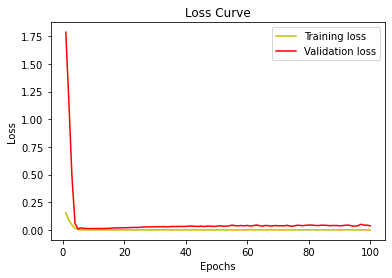

In [308]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
x_train.shape, x_val.shape

((1507, 3), (500, 3))

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.007. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**For the validation set, we have MAE=0.1337. Which seems to be a high number. sum or error divided by 500(500 obs in val set) should give a small MAE. Let's make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [309]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_x = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1)) #[samples, timesteps, features]

In [310]:
# make predictions
testpredict = model.predict(test_x)

16/16 [==============================] - 0s 2ms/step


In [311]:
test_x.shape, testpredict.shape

((501, 3, 1), (501, 1))

In [312]:
# rescale all the observations
testpredict = scaler.inverse_transform(testpredict)
x_train1 = scaler.inverse_transform(x_train)
y_train1 = scaler.inverse_transform(y_train)
x_test1 = scaler.inverse_transform(x_test)
y_test1 = scaler.inverse_transform(y_test)

In [313]:
y_test1

array([[ 94.90200043],
       [ 95.49449921],
       [ 95.26850128],
       [ 94.56549835],
       [ 94.29399872],
       [ 93.61250305],
       [ 94.14949799],
       [ 94.29450226],
       [ 93.25      ],
       [ 94.80449677],
       [ 94.25550079],
       [ 94.5684967 ],
       [ 91.        ],
       [ 92.02500153],
       [ 93.19999695],
       [ 92.90000153],
       [102.57350159],
       [100.52999878],
       [101.4940033 ],
       [103.5510025 ],
       [102.0510025 ],
       [102.09950256],
       [104.25050354],
       [107.54499817],
       [108.16000366],
       [107.24949646],
       [107.78399658],
       [106.25099945],
       [108.38999939],
       [108.65350342],
       [107.10749817],
       [100.15899658],
       [101.32099915],
       [ 98.51399994],
       [ 96.71900177],
       [ 90.73149872],
       [ 95.32450104],
       [ 98.76850128],
       [ 97.32849884],
       [ 96.65000153],
       [ 93.75      ],
       [ 88.69300079],
       [ 93.54399872],
       [ 92

In [314]:
# Evaluate the model
print('Single variable LSTM MAE = ', mean_absolute_error(y_test1, testpredict))

Single variable LSTM MAE =  64.35917729056048


**Plot the prediction model for the number of test days and train days**

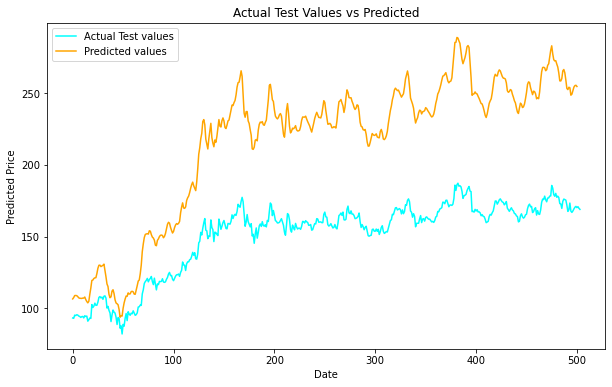

In [315]:
plt.figure(figsize=(10,6))
plt.plot(opentest, color='Cyan', label='Actual Test values')
plt.plot(testpredict , color='Orange', label='Predicted values')
plt.title('Actual Test Values vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


### Obviously, one variable in itself is not generating good results.

### **Using more than one feature**


**We will try LSTM with the best 5 features from the result of the xgboost deature selection. We can than compare the MAE's to check whether more features improves the model.**

In [316]:
data = lstm_df[['Open','Close','High','Low', 'EMA', 'MOMENTUM',]]

In [317]:
data.head()

,Open,Close,High,Low,EMA,MOMENTUM
0,8.7945,8.9515,8.9740,8.7775,8.951500,-0.910485
1,8.9605,8.8755,9.0250,8.8035,8.894500,-0.911245
2,8.7970,8.8805,8.9125,8.7025,8.884808,-0.911195
3,8.9035,9.1305,9.2325,8.8750,9.050650,-0.908695
4,9.1380,8.9280,9.2185,8.8500,8.968546,-0.910720


### Split dataset into train, test and validate sets

In [320]:
#creating test, train and validate trains
train, val, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [322]:
train.shape, val.shape, test.shape

((1510, 6), (503, 6), (504, 6))

### Normalize the data

In [323]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
strain = scaler.fit_transform(train)
sval = scaler.transform(val)
stest = scaler.transform(test)

In [324]:
# For train
Xtrain = []
Ytrain = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtrain.append(strain[i - n_past:i, 0:train.shape[1]])
    Ytrain.append(strain[i + n_future - 1:i + n_future, 0])


In [260]:
# For val
Xval = []
Yval = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(sval) - n_future +1):
    Xval.append(sval[i - n_past:i, 0:val.shape[1]])
    Yval.append(sval[i + n_future - 1:i + n_future, 0])

In [325]:
# For test
Xtest = []
Ytest = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(stest) - n_future +1):
    Xtest.append(stest[i - n_past:i, 0:test.shape[1]])
    Ytest.append(stest[i + n_future - 1:i + n_future, 0])

In [326]:
# change type to array
Xtrain, Ytrain = np.array(Xtrain), np.array(Ytrain)
Xval, Yval = np.array(Xval), np.array(Yval)
Xtest, Ytest = np.array(Xtest), np.array(Ytest)

Xtrain.shape,Ytrain.shape


((1507, 3, 6), (1507, 1))

Learn how to onvert a time series to supervised learning: <br/>
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

## Let' see what reformatting does

In [327]:
data_array = np.array(data)

In [328]:
len(data_array)

2517

In [329]:
# For data
X = []
Y = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(data_array) - n_future +1):
    X.append(data_array[i - n_past:i, 0:data_array.shape[1]])
    Y.append(data_array[i + n_future - 1:i + n_future, 0])

In [330]:
data.head(12)

,Open,Close,High,Low,EMA,MOMENTUM
0,8.7945,8.9515,8.9740,8.7775,8.951500,-0.910485
1,8.9605,8.8755,9.0250,8.8035,8.894500,-0.911245
2,8.7970,8.8805,8.9125,8.7025,8.884808,-0.911195
3,8.9035,9.1305,9.2325,8.8750,9.050650,-0.908695
4,9.1380,8.9280,9.2185,8.8500,8.968546,-0.910720
5,9.0550,8.9670,9.1200,8.8550,8.967514,-0.910330
6,8.9820,8.9450,9.0385,8.9095,8.952498,-0.910550
7,8.9710,8.7965,8.9745,8.7875,8.848483,-0.912035
8,8.7905,8.9210,8.9400,8.6750,8.896830,-0.910790
9,9.0075,9.0830,9.1650,8.9255,9.020946,-0.909170


In [331]:
X

[array([[ 8.79450035,  8.95149994,  8.97399998,  8.77750015,  8.95149994,
         -0.910485  ],
        [ 8.96049976,  8.87549973,  9.02499962,  8.80350018,  8.89449978,
         -0.911245  ],
        [ 8.79699993,  8.88049984,  8.91250038,  8.70250034,  8.88480751,
         -0.911195  ]]),
 array([[ 8.96049976,  8.87549973,  9.02499962,  8.80350018,  8.89449978,
         -0.911245  ],
        [ 8.79699993,  8.88049984,  8.91250038,  8.70250034,  8.88480751,
         -0.911195  ],
        [ 8.9034996 ,  9.13049984,  9.23250008,  8.875     ,  9.05064983,
         -0.908695  ]]),
 array([[ 8.79699993,  8.88049984,  8.91250038,  8.70250034,  8.88480751,
         -0.911195  ],
        [ 8.9034996 ,  9.13049984,  9.23250008,  8.875     ,  9.05064983,
         -0.908695  ],
        [ 9.13799953,  8.92800045,  9.21850014,  8.85000038,  8.9685457 ,
         -0.91072   ]]),
 array([[ 8.9034996 ,  9.13049984,  9.23250008,  8.875     ,  9.05064983,
         -0.908695  ],
        [ 9.13799953,  8

In [332]:
Y

[array([8.9034996]),
 array([9.13799953]),
 array([9.05500031]),
 array([8.98200035]),
 array([8.97099972]),
 array([8.79049969]),
 array([9.00749969]),
 array([9.09700012]),
 array([9.54399967]),
 array([9.53549957]),
 array([9.53950024]),
 array([9.25]),
 array([9.3494997]),
 array([9.46500015]),
 array([9.65450001]),
 array([9.68400002]),
 array([9.69999981]),
 array([8.69050026]),
 array([8.98250008]),
 array([9.14150047]),
 array([9.31400013]),
 array([9.13249969]),
 array([9.24750042]),
 array([9.22500038]),
 array([9.17099953]),
 array([9.35849953]),
 array([9.5539999]),
 array([9.56449986]),
 array([8.88949966]),
 array([9.00450039]),
 array([9.13249969]),
 array([9.09749985]),
 array([8.98200035]),
 array([8.98499966]),
 array([8.87699986]),
 array([8.94499969]),
 array([9.19449997]),
 array([8.99450016]),
 array([8.97399998]),
 array([8.94999981]),
 array([8.93400002]),
 array([9.13249969]),
 array([9.20849991]),
 array([9.33950043]),
 array([9.20650005]),
 array([9.1960001])

In [333]:
# since 3 is the timesteps, see the difference between train and Xtrain samples
train.shape, Xtrain.shape

((1510, 6), (1507, 3, 6))

In [334]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_X = np.reshape(Xtrain, (Xtrain.shape[0],Xtrain.shape[1], 6)) #[samples, timesteps, features]
val_X = np.reshape(Xval, (Xval.shape[0],Xval.shape[1], 6))

### LSTM Model

In [335]:
#instantiate and fit the model

model.reset_states()
model = Sequential()
model.add(LSTM(15, input_shape=(3, 6), activation='relu')) # 3 is the timesteps, 1 is the one from the reshape 
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history
#set verbose=False if you don't want to see the output
history = model.fit(train_X, Ytrain, epochs = 100, batch_size = 32,validation_data = (val_X, Yval))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 15)                1320      
                                                                 
 dense_13 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1,336
Trainable params: 1,336
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 2s 7ms/step - loss: 0.0350 - mean_absolute_error: 0.1208 - val_loss: 0.0027 - val_mean_absolute_error: 0.0409
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 9.0132e-04 - mean_absolute_error: 0.0245 - val_loss: 0.0019 - val_mean_absolute_error: 0.0329
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 1.4256e-04 - mean_absolute_error: 0.008

Epoch 46/100
48/48 [==============================] - 0s 2ms/step - loss: 8.9639e-05 - mean_absolute_error: 0.0058 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285
Epoch 47/100
48/48 [==============================] - 0s 3ms/step - loss: 9.7285e-05 - mean_absolute_error: 0.0062 - val_loss: 0.0015 - val_mean_absolute_error: 0.0282
Epoch 48/100
48/48 [==============================] - 0s 3ms/step - loss: 9.8224e-05 - mean_absolute_error: 0.0062 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284
Epoch 49/100
48/48 [==============================] - 0s 3ms/step - loss: 9.0670e-05 - mean_absolute_error: 0.0059 - val_loss: 0.0015 - val_mean_absolute_error: 0.0281
Epoch 50/100
48/48 [==============================] - 0s 2ms/step - loss: 8.7422e-05 - mean_absolute_error: 0.0059 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285
Epoch 51/100
48/48 [==============================] - 0s 2ms/step - loss: 9.3862e-05 - mean_absolute_error: 0.0061 - val_loss: 0.0015 - val_mean_absolute_error:

Epoch 95/100
48/48 [==============================] - 0s 2ms/step - loss: 9.3839e-05 - mean_absolute_error: 0.0063 - val_loss: 0.0011 - val_mean_absolute_error: 0.0237
Epoch 96/100
48/48 [==============================] - 0s 2ms/step - loss: 7.2289e-05 - mean_absolute_error: 0.0052 - val_loss: 0.0012 - val_mean_absolute_error: 0.0259
Epoch 97/100
48/48 [==============================] - 0s 3ms/step - loss: 7.2211e-05 - mean_absolute_error: 0.0052 - val_loss: 0.0011 - val_mean_absolute_error: 0.0246
Epoch 98/100
48/48 [==============================] - 0s 3ms/step - loss: 7.3672e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0013 - val_mean_absolute_error: 0.0279
Epoch 99/100
48/48 [==============================] - 0s 3ms/step - loss: 7.6115e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 100/100
48/48 [==============================] - 0s 2ms/step - loss: 6.9251e-05 - mean_absolute_error: 0.0051 - val_loss: 0.0011 - val_mean_absolute_error

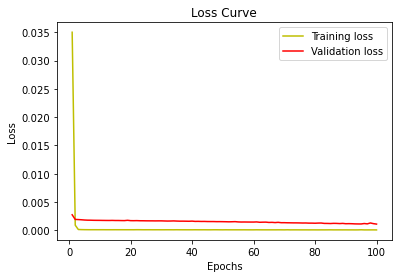

In [336]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.005. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**Same for the validation set. We will now make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [337]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_X = np.reshape(Xtest, (Xtest.shape[0],Xtest.shape[1], 6)) #[samples, timesteps, features]

In [338]:
# make predictions
testpredict = model.predict(test_X)

16/16 [==============================] - 0s 1ms/step


In [339]:
test_X.shape, testpredict.shape

((501, 3, 6), (501, 1))

In [340]:
testpredict

array([[1.7013462],
       [1.6991423],
       [1.7064409],
       [1.69857  ],
       [1.6938262],
       [1.6830169],
       [1.6730008],
       [1.6789271],
       [1.6776496],
       [1.6823493],
       [1.691032 ],
       [1.6858683],
       [1.6836754],
       [1.6412116],
       [1.6498706],
       [1.6591932],
       [1.6643982],
       [1.742263 ],
       [1.788998 ],
       [1.8350191],
       [1.8458185],
       [1.8472524],
       [1.8596101],
       [1.8776988],
       [1.9141104],
       [1.9397033],
       [1.9487786],
       [1.9463706],
       [1.9396011],
       [1.9464381],
       [1.9543613],
       [1.9327874],
       [1.8425515],
       [1.8201119],
       [1.7913939],
       [1.7463723],
       [1.682955 ],
       [1.7233652],
       [1.7416856],
       [1.7608321],
       [1.7447948],
       [1.7069534],
       [1.6386312],
       [1.6746597],
       [1.6516856],
       [1.5555646],
       [1.5740123],
       [1.5152706],
       [1.5880141],
       [1.5986649],


In [341]:
# rescale all the observations
test_prediction_copies = np.repeat(testpredict, 6, axis=-1)
testpred = scaler.inverse_transform(test_prediction_copies)[:,0]
testpred

array([ 96.40085 ,  96.28723 ,  96.6635  ,  96.25773 ,  96.01317 ,
        95.45591 ,  94.939545,  95.24506 ,  95.17921 ,  95.42149 ,
        95.86912 ,  95.602905,  95.48986 ,  93.3007  ,  93.7471  ,
        94.227715,  94.49605 ,  98.510254, 100.91961 , 103.29215 ,
       103.8489  , 103.92282 , 104.559906, 105.49245 , 107.36959 ,
       108.689   , 109.15685 , 109.032715, 108.68372 , 109.036194,
       109.44467 , 108.33245 , 103.68047 , 102.523636, 101.04312 ,
        98.72211 ,  95.45272 ,  97.536   ,  98.480484,  99.46755 ,
        98.64078 ,  96.68992 ,  93.16767 ,  95.02507 ,  93.84067 ,
        88.8853  ,  89.83634 ,  86.808   ,  90.55818 ,  91.10727 ,
        94.20175 ,  96.1311  ,  95.738266,  97.748535,  97.34934 ,
        98.16784 ,  97.576065,  98.746315,  99.43002 ,  98.112175,
        97.40799 ,  97.10881 ,  98.735535, 100.56203 , 102.258415,
       103.37949 , 105.17099 , 108.85136 , 112.60459 , 116.79071 ,
       118.70507 , 120.02085 , 120.46499 , 119.78197 , 119.775

**Plot the prediction model for the number of test days and train days**

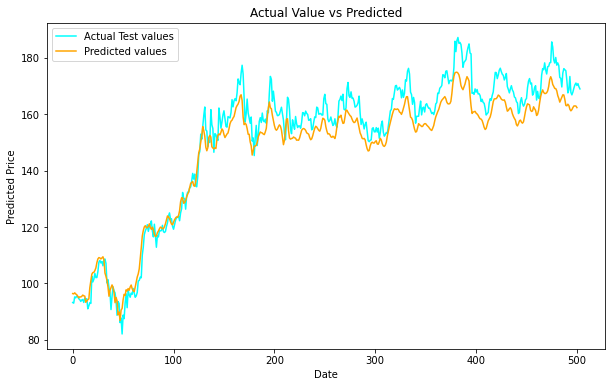

In [342]:
plt.figure(figsize=(10,6))
plt.plot(opentest, color='Cyan', label='Actual Test values')
plt.plot(testpred , color='Orange', label='Predicted values')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


In [343]:
# Evaluate the model
print('Multi variable LSTM MAE = ', mean_absolute_error(Ytest, testpred))

Multi variable LSTM MAE =  143.59998047964726


**The mean absolute error is lower than the past model with one feature. The errror is almost 0.0026. So the training model should be pretty close to testing model.**